In [1]:
%load_ext lab_black

In [2]:
# Google Colab
#!git clone https://github.com/Jez-Carter/Bias_Correction
# !pip install numpyro

In [3]:
# Importing Packages

import os
import timeit
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rc("figure", figsize=(10, 10))
os.environ["PROJ_LIB"] = "C:\\Utilities\\Python\\Anaconda\\Library\\share"
import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS, HMC, BarkerMH
from numpyro.distributions import constraints
import jax.numpy as jnp
from jax import random, vmap, jit
import jax.scipy.stats.gamma as jgamma

# Importing Project Modules:
from src.netcdf_functions import pcolormesh_basemapplot

# Estimating PDF parameter values

From previous literature (Lima, 2021, https://doi.org/10.1016/j.jhydrol.2021.126095) it seems reasonable to assume a Bernoulli-Gamma distribution for daily snowfall. This has the form:

$P(Y_{jk}=y_{jk}) = B(1,p_{jk})\cdot G(y_{jk}|\alpha_{jk},\beta_{jk})$

$B(1,p_{jk})\cdot G(y_{jk}|\alpha_{jk},\beta_{jk}) = \ p_{jk} \cdot \dfrac{{\beta_{jk}}^{\alpha_{jk}} y_{jk}^{\alpha_{jk}-1}e^{-\beta_{jk} y_{jk}}}{\Gamma(\alpha_{jk})} \} \text{Rainfall} $ 

$\ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ (1-p_{jk}) \ \ \ \ \ \ \ \ \ \ \ \} \text{No Rainfall}$

The Bernoulli part gives the probability of rainfall (p) or no rainfall (1-p) on a given day at the site \(j\) for month \(k\) and the Gamma part gives the probability of an intensity of rainfall ($y_{jk}$) on that day given rainfall occurs. The gamma distribution has shape parameter $\alpha$ and scale parameter $\beta$. Note: it makes sense to include a Bernoulli term because of the discontinuity expected for the probability of no rainfall. The shape/scale parameters $\alpha$ and $\beta$ are estimated at every rainfall gauge and for each month of the year. 

Bayesian inference is used to estimate the parameters $p,\alpha,\beta$ for every rainfall gauge and month. 

\begin{equation}
    P(\boldsymbol{p,\alpha,\beta}|\boldsymbol{y}) = P(\boldsymbol{y}|\boldsymbol{p,\alpha,\beta}) \cdot \dfrac{P(\boldsymbol{\boldsymbol{p,\alpha,\beta}})}{P(\boldsymbol{y})} \propto P(\boldsymbol{y}|\boldsymbol{p,\alpha,\beta})\cdot P(\boldsymbol{p,\alpha,\beta})
\end{equation}

\begin{equation}
    P(\boldsymbol{y}|\boldsymbol{p,\alpha,\beta}) \cdot P(\boldsymbol{\boldsymbol{p,\alpha,\beta}}) =
    (\prod_{jk} B(1,p_{jk})\cdot G(y_{jk}|\alpha_{jk},\beta_{jk})) \cdot P(\boldsymbol{p,\alpha,\beta})
\end{equation}

## Bayesian Inference

We are treating the parameters $[p,\alpha,\beta]$ as stochastic variables here with probability distributions to estimate (the posterior distribution). In addition to simply estimating the parameters that maximise our likelihood, this also allows us to estimate a credible interval and plot the uncertainty on our modelled PDF of snowfall.

$Posterior = \dfrac{Likelihood \cdot Prior}{Normalising Constant} $

$P(\boldsymbol{p,\alpha,\beta}|\boldsymbol{y}) = \dfrac{P(\boldsymbol{y}|\boldsymbol{p,\alpha,\beta}) \cdot P(\boldsymbol{\boldsymbol{p,\alpha,\beta}})}{P(\boldsymbol{y})} $

$P(\boldsymbol{y}|\boldsymbol{p,\alpha,\beta})\cdot P(\boldsymbol{p,\alpha,\beta}) = \prod_{i} B(1,p)\cdot G(y_{i}|\alpha,\beta)\cdot P(p,\alpha,\beta)$

$P(\boldsymbol{y}) = \iiint\limits_{\theta} P(\boldsymbol{y}|\boldsymbol{p,\alpha,\beta})\cdot P(\boldsymbol{p,\alpha,\beta}) \,dp\,d\alpha\,d\beta$

Note we don't need the normalising constant to estimate the most likely values of the parameters $\theta=[p,\alpha,\beta]$ (MAP), but we do need it for normalising the distributions of the parameters and so for uncertainty estimates. Note also that MLE is just MAP but with uniform priors and that MAP is not much more difficult than MLE and can be done with a basic minimizer. The point of full Bayesian inference is we are actually getting a posterior probability, which is harder to do than to just maximise it. This gives us a distribution over the parameters with which to construct credibility intervals. 


## Multiple Sites, Multiple Months Example

For multiple sites (j) and multiple months (k) we have:

$P(\boldsymbol{Y}=\boldsymbol{y_i}) = B(1,\boldsymbol{p})\cdot G(\boldsymbol{y_i}|\boldsymbol{\alpha},\boldsymbol{\beta})$

Where:

$\boldsymbol{Y}=[Y_{00},Y_{01},Y_{1,0},...,Y_{jk}]$

$\boldsymbol{y}=[y_{00},y_{01},y_{1,0},...,y_{jk}]$

$\boldsymbol{p}=[p_{00},p_{01},p_{1,0},...,p_{jk}]$

$\boldsymbol{\alpha}=[\alpha_{00},\alpha_{01},\alpha_{1,0},...,\alpha_{jk}]$

$\boldsymbol{\beta}=[\beta_{00},\beta_{01},\beta_{1,0},...,\beta_{jk}]$

$P(Y_{jk}=y_{jk}) = B(1,p_{jk})\cdot G(y_{jk}|\alpha_{jk},\beta_{jk})$

$B(1,p_{jk})\cdot G(y_{jk}|\alpha_{jk},\beta_{jk}) = \ p_{jk} \cdot \dfrac{{\beta_{jk}}^{\alpha_{jk}} y_{jk}^{\alpha_{jk}-1}e^{-\beta_{jk} y_{jk}}}{\Gamma(\alpha_{jk})} \} \text{Rainfall} $ 

$\ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ (1-p_{jk}) \ \ \ \ \ \ \ \ \ \ \ \} \text{No Rainfall}$

Now in Lima, 2021 to deal with the impact of seasonality the model is run for individual months (k) at a time. It is also noted that there exists a spatial correlation between $\alpha_{jk}$ and $\beta_{jk}$, which we want to preserve in the model and so we specify $\beta_{jk}$ as a log normally distributed linear function of $\alpha_{jk}$:

$\beta_{jk} \sim  LN(a_0+a_1 \cdot \alpha_{jk},\sigma^{2})$

The set of parameters $[a_0,a_1,\sigma]$ are hyper-parameters, in that they are not dependent on j (Note they are allowed to be dependent on k).


$Likelihood = P(\boldsymbol{Y}|\boldsymbol{p},\boldsymbol{\alpha},\beta) = \prod_\limits{jk}P(Y_{jk}|p_{jk},\alpha_{jk},a_{0k},a_{1k},{\sigma_k}^2) = \prod_\limits{ijk} B(1,p_{jk})\cdot G(y_{i}|\alpha_{jk},a_{0k},a_{1k},{\sigma_k}^2)$

$Log Likehood = Log(\prod_\limits{ijk} B(1,p_{jk})\cdot G(y_{i}|\alpha_{jk},a_{0k},a_{1k},{\sigma_k}^2)) = \sum_\limits{ijk} Log(B(1,p_{jk})\cdot G(y_{i}|\alpha_{jk},a_{0k},a_{1k},{\sigma_k}^2))$

### Bayesian Inference

In [4]:
jan_data = np.load(
    "/data/notebooks/jupyterlab-biascorrlab/data/multi_site_jan_precip.npy"
)  # This is 38 years of daily data for January

feb_data = np.load(
    "/data/notebooks/jupyterlab-biascorrlab/data/multi_site_feb_precip.npy"
)  # This is 38 years of daily data for February

In [5]:
data_list = [jan_data, feb_data]

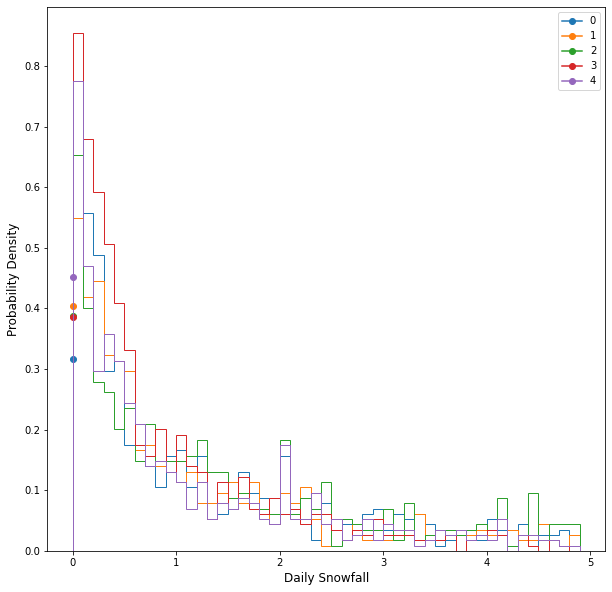

In [6]:
# Plotting the Probability Distributions for each Site for January as a Histogram

for i in np.arange(0, 5, 1):
    data = data_list[0][:, i]
    bins = np.arange(0, 5, 0.1)
    bin_width = bins[1] - bins[0]
    p = len(data[data != 0]) / len(data)
    weight_value = p / bin_width / len(data[data != 0])
    weights = np.full(len(data[data != 0]), weight_value)

    color = next(plt.gca()._get_lines.prop_cycler)["color"]
    plt.hist(
        data[data != 0],
        bins=bins,
        histtype="step",
        stacked=True,
        fill=False,
        weights=weights,
        color=color,
    )
    plt.plot(0, 1 - len(data[data != 0]) / len(data), marker="o", color=color, label=i)
    plt.xlabel("Daily Snowfall", fontsize=12)
    plt.ylabel("Probability Density", fontsize=12)
    plt.legend()
    # plt.show()

In [7]:
# Converting dataset to jax dataset
jdata_list = [jnp.array(jan_data), jnp.array(feb_data)]

In [8]:
class BernoulliGamma(numpyro.distributions.Distribution):
    support = constraints.positive

    def __init__(self, params):
        self.p = params[0]
        self.alpha = params[1]
        self.scale = params[2]
        super().__init__(batch_shape=jnp.shape(params[0]), event_shape=())

    def sample(self, key, sample_shape=()):
        raise NotImplementedError

    def log_prob(self, value):

        return jnp.log(1 - self.p) * jnp.sum(
            jnp.where(value == 0, 1, 0), axis=0
        ) + jnp.sum(
            jnp.where(
                value != 0,
                jnp.log(
                    self.p
                    * jgamma.pdf(
                        jnp.where(value == 0, 1, value),
                        a=self.alpha,
                        loc=0,
                        scale=self.scale,
                    )  # Note I use np.where because jax and jit compiling doesn't work with list comprehension (e.g. [value[value!=0]]) (In addition I use it to avoid computing gamma for values of 0).
                ),
                0,
            ),
            axis=0,
        )

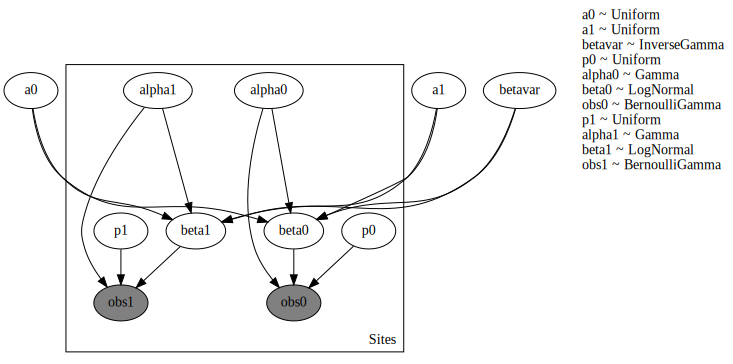

In [9]:
# Model with for loop


def parametric_dependency_model(data_seperate_month_list):

    # Hyper-Params: (These the parameters used to parameterise beta as a function of alpha
    a0 = numpyro.sample(f"a0", dist.Uniform(-10, 10.0))
    a1 = numpyro.sample(f"a1", dist.Uniform(-10, 10.0))
    betavar = numpyro.sample(f"betavar", dist.InverseGamma(0.001, 0.001))

    months = len(data_seperate_month_list)
    sites = data_seperate_month_list[0].shape[1]

    for k in np.arange(0, months, 1):
        with numpyro.plate("Sites", sites) as j:
            # Plate essentially vectorises all the below, so for example where sites = 5, the shape of p,alpha and scale defined below will be vectors of length 5
            data = data_seperate_month_list[k][:, j]

            p = numpyro.sample(f"p{k}", dist.Uniform(0, 1.0))
            alpha = numpyro.sample(f"alpha{k}", dist.Gamma(0.001, 0.001))
            scale = jnp.reciprocal(
                numpyro.sample(
                    f"beta{k}",
                    dist.LogNormal(
                        a0 + a1 * alpha,
                        betavar,
                    ),
                )
            )

            numpyro.sample(
                f"obs{k}",
                BernoulliGamma([p, alpha, scale]),
                obs=data,
            )


numpyro.render_model(
    parametric_dependency_model, model_args=(jdata_list,), render_distributions=True
)

In [10]:
with numpyro.handlers.seed(rng_seed=1):
    trace = numpyro.handlers.trace(parametric_dependency_model).get_trace(jdata_list)
print(numpyro.util.format_shapes(trace))

Trace Shapes:         
 Param Sites:         
Sample Sites:         
      a0 dist        |
        value        |
      a1 dist        |
        value        |
 betavar dist        |
        value        |
  Sites plate      5 |
      p0 dist      5 |
        value      5 |
  alpha0 dist      5 |
        value      5 |
   beta0 dist      5 |
        value      5 |
    obs0 dist      5 |
        value 1147 5 |
      p1 dist      5 |
        value      5 |
  alpha1 dist      5 |
        value      5 |
   beta1 dist      5 |
        value      5 |
    obs1 dist      5 |
        value 1045 5 |


In [11]:
# Numpyro syntax for running MCMC
starttime = timeit.default_timer()

# Start from this source of randomness. We will split keys for subsequent operations.
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

# Run NUTS.
kernel = NUTS(parametric_dependency_model)
# kernel = HMC(model)
# kernel = BarkerMH(model)
num_samples = 2000
num_warmup = 1000
mcmc = MCMC(
    kernel, num_warmup=num_warmup, num_samples=num_samples
)  # ,chain_method='vectorized',num_chains=2)
mcmc.run(rng_key_, jdata_list)
mcmc.print_summary()
samples_1 = mcmc.get_samples()

print("Time Taken:", timeit.default_timer() - starttime)

/tmp/ipykernel_27477/4050371456.py:17: UserWarning: Missing a plate statement for batch dimension -2 at site 'obs0'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.
  mcmc.run(rng_key_, jdata_list)
/tmp/ipykernel_27477/4050371456.py:17: UserWarning: Missing a plate statement for batch dimension -2 at site 'obs1'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.
  mcmc.run(rng_key_, jdata_list)
sample: 100%|██████████| 3000/3000 [00:56<00:00, 53.41it/s, 63 steps of size 5.31e-02. acc. prob=0.93] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        a0     -4.03      1.12     -4.01     -5.66     -2.17    664.37      1.00
        a1      3.91      1.56      3.88      1.59      6.38    661.42      1.00
 alpha0[0]      0.64      0.03      0.64      0.60      0.68   1721.58      1.00
 alpha0[1]      0.65      0.03      0.65      0.61      0.70   1402.69      1.00
 alpha0[2]      0.79      0.04      0.79      0.73      0.85   1863.61      1.00
 alpha0[3]      0.82      0.04      0.82      0.76      0.88   1473.98      1.00
 alpha0[4]      0.68      0.03      0.68      0.63      0.73   1518.87      1.00
 alpha1[0]      0.67      0.03      0.67      0.63      0.72   1480.23      1.00
 alpha1[1]      0.65      0.03      0.65      0.60      0.70   1768.08      1.00
 alpha1[2]      0.79      0.04      0.79      0.73      0.85   1518.54      1.00
 alpha1[3]      0.86      0.04      0.86      0.79      0.92   1309.61      1.00
 alpha1[4]      0.66      0

In [12]:
jdata = jnp.array([jan_data[:1000, :], feb_data[:1000, :]])

In [13]:
jdata.shape

(2, 1000, 5)

In [14]:
jdata = np.moveaxis(jdata, 1, 0)

In [15]:
jdata.shape

(1000, 2, 5)

In [16]:
def parametric_dependency_model(jdata):

    # Hyper-Params: (These the parameters used to parameterise beta as a function of alpha
    a0 = numpyro.sample(f"a0", dist.Uniform(-10, 10.0))
    a1 = numpyro.sample(f"a1", dist.Uniform(-10, 10.0))
    betavar = numpyro.sample(f"betavar", dist.InverseGamma(0.001, 0.001))

    months = jdata.shape[1]
    sites = jdata.shape[2]

    with numpyro.plate("Months", months, dim=-2) as k:
        with numpyro.plate("Sites", sites, dim=-1) as j:
            data = jdata

            p = numpyro.sample(f"p", dist.Uniform(0, 1.0))
            alpha = numpyro.sample(f"alpha", dist.Gamma(0.001, 0.001))
            scale = jnp.reciprocal(
                numpyro.sample(
                    f"beta",
                    dist.LogNormal(
                        a0 + a1 * alpha,
                        betavar,
                    ),
                )
            )

            numpyro.sample(
                f"obs",
                BernoulliGamma([p, alpha, scale]),
                obs=jdata,
            )

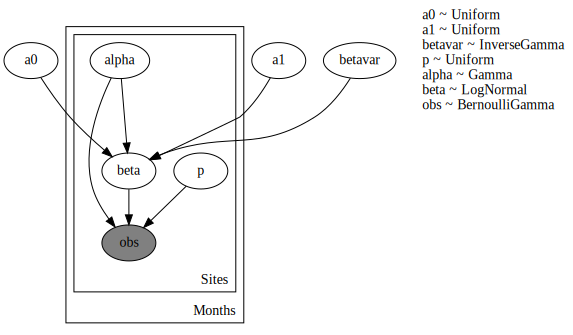

In [17]:
numpyro.render_model(
    parametric_dependency_model, model_args=(jdata,), render_distributions=True
)

In [18]:
with numpyro.handlers.seed(rng_seed=1):
    trace = numpyro.handlers.trace(parametric_dependency_model).get_trace(jdata)
print(numpyro.util.format_shapes(trace))

Trace Shapes:           
 Param Sites:           
Sample Sites:           
      a0 dist          |
        value          |
      a1 dist          |
        value          |
 betavar dist          |
        value          |
 Months plate        2 |
  Sites plate        5 |
       p dist      2 5 |
        value      2 5 |
   alpha dist      2 5 |
        value      2 5 |
    beta dist      2 5 |
        value      2 5 |
     obs dist      2 5 |
        value 1000 2 5 |


In [19]:
# Numpyro syntax for running MCMC
starttime = timeit.default_timer()

# Start from this source of randomness. We will split keys for subsequent operations.
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

# Run NUTS.
kernel = NUTS(parametric_dependency_model)
# kernel = HMC(model)
# kernel = BarkerMH(model)
num_samples = 2000
num_warmup = 1000
mcmc = MCMC(
    kernel,
    num_warmup=num_warmup,
    num_samples=num_samples,
    #    chain_method="vectorized",
    num_chains=1,
)
mcmc.run(rng_key_, jdata)
mcmc.print_summary()
samples_1 = mcmc.get_samples()

print("Time Taken:", timeit.default_timer() - starttime)

/tmp/ipykernel_27477/1057684537.py:21: UserWarning: Missing a plate statement for batch dimension -3 at site 'obs'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.
  mcmc.run(rng_key_, jdata)
sample: 100%|██████████| 3000/3000 [00:34<00:00, 85.91it/s, 63 steps of size 6.51e-02. acc. prob=0.75]  



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        a0     -4.04      1.05     -3.94     -5.58     -2.29    364.01      1.01
        a1      3.92      1.45      3.80      1.61      6.17    369.76      1.01
alpha[0,0]      0.65      0.03      0.65      0.60      0.69     38.40      1.04
alpha[0,1]      0.63      0.03      0.63      0.58      0.68     36.50      1.04
alpha[0,2]      0.78      0.04      0.78      0.72      0.84   1225.00      1.00
alpha[0,3]      0.83      0.04      0.83      0.77      0.89     94.88      1.02
alpha[0,4]      0.69      0.03      0.69      0.64      0.75    754.35      1.00
alpha[1,0]      0.68      0.03      0.68      0.63      0.73     50.62      1.03
alpha[1,1]      0.66      0.03      0.66      0.61      0.71     49.04      1.03
alpha[1,2]      0.79      0.04      0.79      0.73      0.84    391.67      1.00
alpha[1,3]      0.87      0.04      0.87      0.80      0.93     43.18      1.04
alpha[1,4]      0.67      0

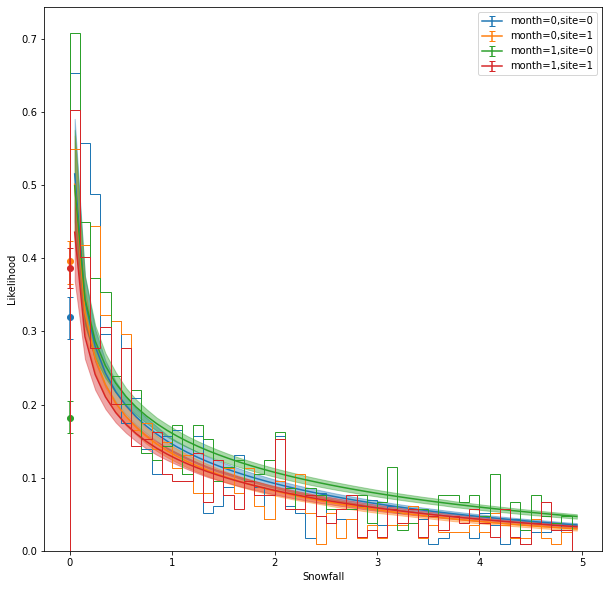

In [20]:
# Plotting the PDFs estimated for 2 different sites for January and February (The credible interval containing 95% of expected variation is also plotted)

for k in np.arange(0, 2, 1):
    for j in np.arange(0, 2, 1):

        ps = jnp.expand_dims(samples_1[f"p"], -1)[:, k, j]
        alphas = jnp.expand_dims(samples_1[f"alpha"], -1)[:, k, j]
        scales = jnp.reciprocal(jnp.expand_dims(samples_1[f"beta"], -1))[:, k, j]

        bins = np.arange(0, 5, 0.1)
        bin_centers = bins + bins[1] / 2

        likelihood_values = ps * jgamma.pdf(bin_centers, a=alphas, loc=0, scale=scales)

        zero_likelihood_values = 1 - ps

        mean_l = jnp.mean(jnp.array(likelihood_values), axis=0)
        hpdi_l = hpdi(jnp.array(likelihood_values), 0.95)
        lower_l = hpdi_l[0]
        upper_l = hpdi_l[1]

        zero_mean_l = jnp.mean(jnp.array(zero_likelihood_values), axis=0)
        zero_hpdi_l = hpdi(jnp.array(zero_likelihood_values), 0.95)
        zero_lower_l = zero_hpdi_l[0]
        zero_upper_l = zero_hpdi_l[1]
        zero_lower_error = zero_mean_l - zero_lower_l
        zero_upper_error = zero_upper_l - zero_mean_l
        error = np.array([zero_lower_error[0], zero_upper_error[0]]).reshape(2, 1)

        data = data_list[k][:, j]
        bin_width = bins[1] - bins[0]
        p_data = len(data[data != 0]) / len(data)
        weight_value = p_data / bin_width / len(data[data != 0])
        weights = np.full(len(data[data != 0]), weight_value)

        color = next(plt.gca()._get_lines.prop_cycler)["color"]

        plt.hist(
            data[data != 0],
            bins=bins,
            histtype="step",
            stacked=True,
            fill=False,
            weights=weights,
            color=color,
        )

        plt.plot(bin_centers, mean_l, color=color)
        plt.fill_between(bin_centers, y1=lower_l, y2=upper_l, alpha=0.4, color=color)

        plt.plot(0, 1 - ps.mean(), marker="o", color=color)
        plt.errorbar(
            0,
            zero_mean_l,
            yerr=error,
            capsize=3,
            color=color,
            label=f"month={k},site={j}",
        )

plt.xlabel("Snowfall")
plt.ylabel("Likelihood")
plt.legend()

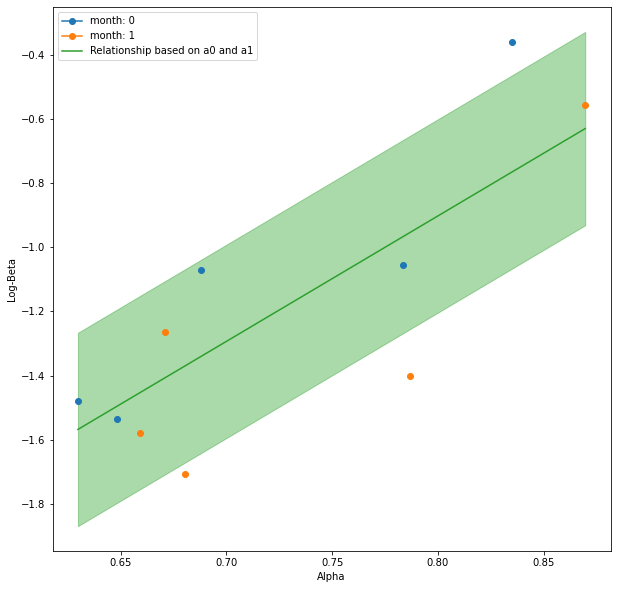

In [21]:
# Examining the parametric relationship between Alpha and Beta

alpha_mean_list = []
a0 = jnp.expand_dims(samples_1[f"a0"], -1)
a1 = jnp.expand_dims(samples_1[f"a1"], -1)
betavar = jnp.expand_dims(samples_1[f"betavar"], -1)
for k in np.arange(0, 2, 1):
    color = next(plt.gca()._get_lines.prop_cycler)["color"]
    for j in np.arange(0, 5, 1):
        alphas = jnp.expand_dims(samples_1[f"alpha"][:, k, j], -1)
        alpha_mean_list.append(jnp.mean(alphas))
        betas = jnp.expand_dims(samples_1[f"beta"][:, k, j], -1)
        plt.plot(
            jnp.mean(alphas),
            jnp.mean(jnp.log(betas)),
            marker="o",
            color=color,
            label=f"month: {k}",
        )

x = [jnp.min(jnp.array(alpha_mean_list)), jnp.max(jnp.array(alpha_mean_list))]
y = jnp.mean(a0) + jnp.mean(a1) * jnp.array(x)
color = next(plt.gca()._get_lines.prop_cycler)["color"]
plt.plot(x, y, label="Relationship based on a0 and a1", color=color)
plt.fill_between(
    x,
    y1=y - jnp.mean(betavar),
    y2=y + jnp.mean(betavar),
    alpha=0.4,
    color=color,
)
plt.xlabel("Alpha")
plt.ylabel("Log-Beta")
# Below is some code for plotting a non-repeating legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())